### 叶子元素分布探索

In [1]:
# coding: utf-8
import pandas as pd
import numpy as np
import time
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

from package.utils import KPIPoint
from package.utils import KPISet
from package.utils import Explore
from package.utils import Evalutaion
from package.HotSpot import HotSpot

In [2]:
def exploreLeaf(KPIType, time_start, time_end, time_interval):
    # 加载数据
    kSet = KPISet({}, {})
    kSet.load('../result/metadata/%s' % KPIType)
    
    leaves_count = {}
    # 遍历时间戳，获取叶子元素
    for timestamp in kSet._KPIPoints:
        for leaf in kSet._KPIPoints[timestamp]._leaf:
            if leaf not in leaves_count:
                leaves_count[leaf] = 0
            leaves_count[leaf] += 1
    # 倒序排列
    leaves_count = dict(sorted(leaves_count.items(), key=lambda c : c[1], reverse=True))

    print('非重复叶子元素个数：', len(leaves_count))
    
    # 获取叶子元素时间序列
    filePath = ('../result/leaves/leaves_%s' % KPIType)
    if not os.path.exists(filePath):
        os.makedirs(filePath)    
    for leaf in list(leaves_count.keys()):
        ts = kSet.get_ts_leaf(leaf=leaf, t1=time_start, t2=time_end, delta=time_interval)
        ts = pd.DataFrame(ts)
        ts.to_csv('%s/%s_%d.csv' % (filePath, "&".join(leaf), leaves_count[leaf]), index=False)
    
    # 返回结果
    df = {}
    df['leaf'] = list(leaves_count.keys())
    df['count'] = list(leaves_count.values())
    df = pd.DataFrame(df)
    
    # 可视化
    plt.figure(figsize=(80, 10))
    plt.xlabel('leaf')
    plt.ylabel('count')
    plt.title('leaf count in 2 weeks')
    plt.plot(df['count'].tolist(), 'g', label='KPI')
    plt.show()
    
    return df

In [3]:
def str2tuple(string):
    leaf = string.replace('\"', "").replace('\'', "").replace(' ', "").replace('(', "").replace(')', "").split(',')
    return tuple(leaf)

In [4]:
# leafFirst2Week = exploreLeaf('KPISet', 1535731200, 1536940500, 300)
# leafFirst2Week.to_csv('../result/leaves/leafCountTrain.csv', index=False)
# leafFirst2Week['count'].to_csv('../result/leaves/leafCountTrain_withoutLeaf.csv', index=False)
leafFirst2Week = pd.read_csv('../result/leaves/leafCountTrain.csv')

# leafLast2Week = exploreLeaf('KPISetTest')
# leafLast2Week.to_csv('../result/leaves/leafCountTest.csv', index=False)
# leafLast2Week['count'].to_csv('../result/leaves/leafCountTest_withoutLeaf.csv', index=False)

In [5]:
leafFirst2Week.describe()

,count
count,15149.000000
mean,645.233481
std,1138.378580
min,1.000000
25%,5.000000
50%,48.000000
75%,660.000000
max,4032.000000


#### 叶子元素统计信息

In [6]:
leafFirst2Week['leaf'] = leafFirst2Week['leaf'].apply(str2tuple)
explore = Explore()
stat = explore.statistic('../result/leaves/leaves_KPISet', leafFirst2Week['leaf'], 'true', 2016)
leafFirst2Week = leafFirst2Week.merge(stat, on=['leaf'], how='left')

  0%|          | 0/15149 [00:00<?, ?it/s]/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
 32%|███▏      | 4889/15149 [05:45<14:13, 12.02it/s]/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:475: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]
100%|██████████| 15149/15149 [17:53<00:0

In [7]:
stat_smothing = explore.statistic('../result/leaves/leaves_KPISet_smothing', leafFirst2Week['leaf'], 'smoothed', 2016)
cols = ['diff', 'isWhiteNoise', 'min', 'max', 'mean', 'std']
for col in cols:
    stat_smothing.rename(columns={col : col+'_smooth'}, inplace=True)
leafFirst2Week = leafFirst2Week.merge(stat_smothing, on=['leaf'], how='left')

 32%|███▏      | 4839/15149 [05:23<13:50, 12.42it/s]/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:660: RuntimeWarning: divide by zero encountered in log
  llf = -nobs2*np.log(2*np.pi) - nobs2*np.log(ssr / nobs) - nobs2
/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/Users/Jeremy/miniconda3/envs/ml/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:475: RuntimeWarning: invalid value encountered in true_divide
  acf = avf[:nlags + 1] / avf[0]
100%|██████████| 15149/15149 [15:57<00:00, 15.82it/s] 


#### 保存统计信息

In [8]:
leafFirst2Week.to_csv('../result/leaves/leafCountTrainStatistic.csv', index=False)
leafFirst2Week = pd.read_csv('../result/leaves/leafCountTrainStatistic.csv')
leafFirst2Week['leaf'] = leafFirst2Week['leaf'].apply(str2tuple)

In [9]:
leafFirst2Week.describe()

,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
count,15149.000000,15149.000000,15149.000000,1.514900e+04,15149.000000,15149.000000,15149.000000,15149.000000,15149.000000,15149.000000,15149.000000,15149.000000,15149.000000
mean,645.233481,0.089379,0.463529,6.640020e+02,3.871609,85.068165,62.976288,0.017889,0.558981,264.972869,3.871609,83.564476,51.317468
std,1138.378580,10.115562,0.498685,1.067783e+04,91.859737,1550.161797,1024.406854,1.084682,0.496525,4347.809378,91.859737,1543.163612,842.403241
min,1.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000248,0.015747,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,3.000000e+00,0.000000,0.002728,0.072097,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,48.000000,0.000000,0.000000,1.000000e+01,0.000000,0.028274,0.350761,0.000000,1.000000,1.000000,0.000000,0.000496,0.022266
75%,660.000000,0.000000,1.000000,5.200000e+01,0.000000,0.642361,2.551369,0.000000,1.000000,8.000000,0.000000,0.411706,1.173936
max,4032.000000,1245.000000,1.000000,1.045908e+06,6414.000000,98874.505952,77612.717391,133.000000,1.000000,256735.000000,6414.000000,98826.512649,49878.567250


### 分析

In [10]:
lenAll = len(leafFirst2Week)

#### 时间序列平稳性

In [11]:
leafFirst2Week

,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
0,"(i38, e10, c1, p10, l3)",4032,0,0,155294,3548,57780.765625,29841.522919,0,0,145996,3548,57760.683780,29788.155752
1,"(i06, e10, c5, p19, l3)",4032,0,0,337141,4546,78136.378224,37615.773298,0,0,189199,4546,77869.410962,36696.924262
2,"(i38, e10, c1, p13, l3)",4032,0,0,29623,321,9415.018353,4670.152889,0,0,23269,321,9403.066964,4638.199768
3,"(i38, e10, c1, p10, l1)",4032,0,0,4096,1,127.605903,121.192427,0,0,491,1,125.182788,91.135072
4,"(i02, e08, c1, p19, l3)",4032,0,0,5698,63,1405.138393,1077.521768,0,0,4625,63,1403.395337,1072.633302
5,"(i06, e10, c5, p18, l3)",4032,0,0,60682,938,19029.216766,9310.830318,0,0,42582,938,19020.726190,9281.472042
6,"(i06, e10, c5, p14, l4)",4032,0,0,4880,46,1208.133185,634.320192,0,0,3052,46,1206.463542,628.979019
7,"(i38, e11, c1, p07, l2)",4032,0,0,912,7,157.117808,82.324517,0,0,395,7,155.480407,77.053975
8,"(i38, e10, c1, p21, l4)",4032,0,0,6677,61,1643.181052,901.175514,0,0,4332,61,1638.103423,887.068840
9,"(i06, e08, c5, p01, l2)",4032,0,0,10762,162,1883.496280,1072.264618,0,0,5074,162,1868.519097,1017.158666


In [12]:
for diff in leafFirst2Week['diff'].unique():
    stationary = leafFirst2Week[leafFirst2Week['diff'] == diff]
    print('进行%d阶差分后平稳的时间序列个数：%d, 占比%f' % (diff, len(stationary), len(stationary) / lenAll))
leafFirst2Week[leafFirst2Week['diff']==1245]

进行0阶差分后平稳的时间序列个数：15039, 占比0.992739
进行1阶差分后平稳的时间序列个数：109, 占比0.007195
进行1245阶差分后平稳的时间序列个数：1, 占比0.000066


,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
11578,"(i33, e11, c1, p06, l3)",5,1245,1,18,0,0.008433,0.350635,0,1,1,0,0.000744,0.027267


#### 预处理前为白噪声的比例

In [13]:
# 预处理后
isWN = leafFirst2Week[leafFirst2Week['isWhiteNoise'] == 1]
isNWN = leafFirst2Week[leafFirst2Week['isWhiteNoise'] == 0]
print('预处理前，白噪声序列个数%d, 占比%f' % (len(isWN), len(isWN) / lenAll))
print('预处理前，非白噪声序列个数%d, 占比%f' % (len(isNWN), len(isNWN) / lenAll))

# 预处理前
isWNS = leafFirst2Week[leafFirst2Week['isWhiteNoise_smooth'] == 1]
isNWNS = leafFirst2Week[leafFirst2Week['isWhiteNoise_smooth'] == 0]
print('预处理后，白噪声序列个数%d, 占比%f' % (len(isWNS), len(isWNS) / lenAll))
print('预处理后，非白噪声序列个数%d, 占比%f' % (len(isNWNS), len(isNWNS) / lenAll))

isWNSNWN = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 1) & (leafFirst2Week['isWhiteNoise_smooth'] == 0)]
isNWNSWN = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 0) & (leafFirst2Week['isWhiteNoise_smooth'] == 1)]
print('预处理后，白噪声转化为非白噪声序列个数%d, 占比%f' % (len(isWNSNWN), len(isWNSNWN) / len(isWN)))
print('预处理后，非白噪声转化为白噪声序列个数%d, 占比%f' % (len(isNWNSWN), len(isNWNSWN) / len(isNWN)))

预处理前，白噪声序列个数7022, 占比0.463529
预处理前，非白噪声序列个数8127, 占比0.536471
预处理后，白噪声序列个数8468, 占比0.558981
预处理后，非白噪声序列个数6681, 占比0.441019
预处理后，白噪声转化为非白噪声序列个数471, 占比0.067075
预处理后，非白噪声转化为白噪声序列个数1917, 占比0.235880


#### 观察白噪声数据的特点

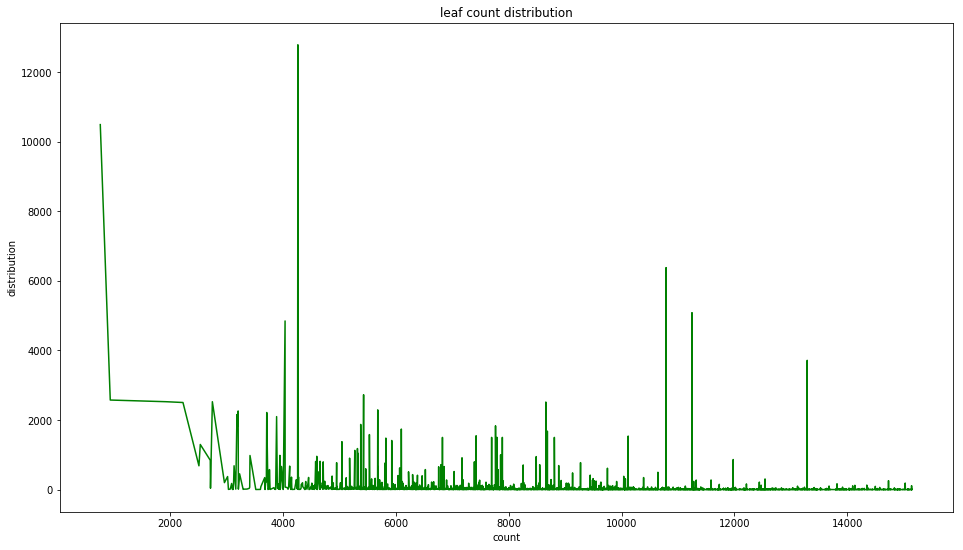

预处理前，白噪声中最大值小于500的时间序列个数为6947,占比为98.931928%
预处理前，白噪声中最大值小于490的时间序列个数为6946,占比为98.917687%
预处理前，白噪声中最大值小于480的时间序列个数为6945,占比为98.903446%
预处理前，白噪声中最大值小于470的时间序列个数为6945,占比为98.903446%
预处理前，白噪声中最大值小于460的时间序列个数为6945,占比为98.903446%
预处理前，白噪声中最大值小于450的时间序列个数为6944,占比为98.889205%
预处理前，白噪声中最大值小于440的时间序列个数为6944,占比为98.889205%
预处理前，白噪声中最大值小于430的时间序列个数为6943,占比为98.874964%
预处理前，白噪声中最大值小于420的时间序列个数为6942,占比为98.860723%
预处理前，白噪声中最大值小于410的时间序列个数为6940,占比为98.832242%
预处理前，白噪声中最大值小于400的时间序列个数为6939,占比为98.818001%
预处理前，白噪声中最大值小于390的时间序列个数为6936,占比为98.775278%
预处理前，白噪声中最大值小于380的时间序列个数为6934,占比为98.746796%
预处理前，白噪声中最大值小于370的时间序列个数为6933,占比为98.732555%
预处理前，白噪声中最大值小于360的时间序列个数为6932,占比为98.718314%
预处理前，白噪声中最大值小于350的时间序列个数为6931,占比为98.704073%
预处理前，白噪声中最大值小于340的时间序列个数为6927,占比为98.647109%
预处理前，白噪声中最大值小于330的时间序列个数为6927,占比为98.647109%
预处理前，白噪声中最大值小于320的时间序列个数为6926,占比为98.632868%
预处理前，白噪声中最大值小于310的时间序列个数为6923,占比为98.590145%
预处理前，白噪声中最大值小于300的时间序列个数为6921,占比为98.561663%
预处理前，白噪声中最大值小于290的时间序列个数为6921,占比为98.561663%
预处理前，白噪声中最大值小于280的时间序列个数为6917,占比

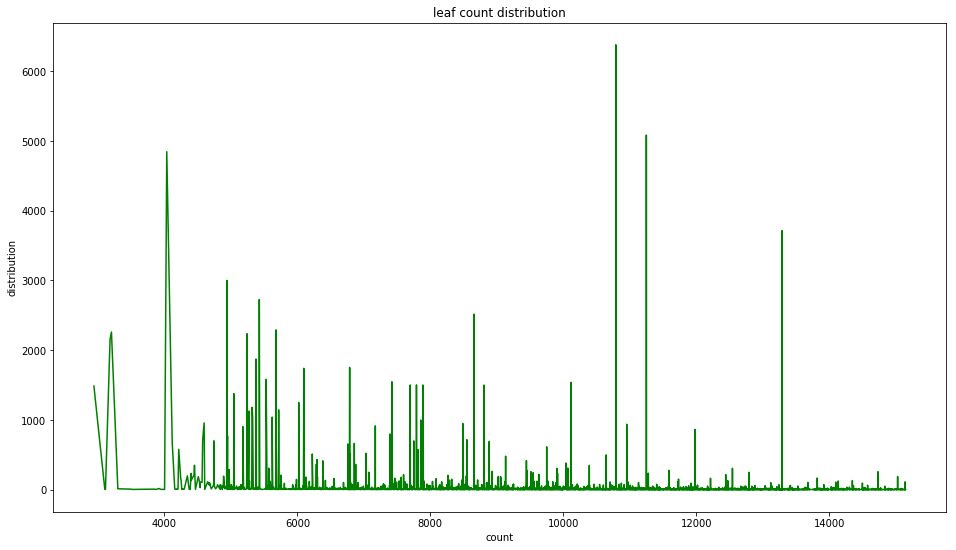

预处理后，白噪声中最大值小于500的时间序列个数为8415,占比为99.374114%
预处理后，白噪声中最大值小于490的时间序列个数为8414,占比为99.362305%
预处理后，白噪声中最大值小于480的时间序列个数为8413,占比为99.350496%
预处理后，白噪声中最大值小于470的时间序列个数为8413,占比为99.350496%
预处理后，白噪声中最大值小于460的时间序列个数为8413,占比为99.350496%
预处理后，白噪声中最大值小于450的时间序列个数为8413,占比为99.350496%
预处理后，白噪声中最大值小于440的时间序列个数为8413,占比为99.350496%
预处理后，白噪声中最大值小于430的时间序列个数为8412,占比为99.338687%
预处理后，白噪声中最大值小于420的时间序列个数为8412,占比为99.338687%
预处理后，白噪声中最大值小于410的时间序列个数为8410,占比为99.315068%
预处理后，白噪声中最大值小于400的时间序列个数为8410,占比为99.315068%
预处理后，白噪声中最大值小于390的时间序列个数为8410,占比为99.315068%
预处理后，白噪声中最大值小于380的时间序列个数为8409,占比为99.303259%
预处理后，白噪声中最大值小于370的时间序列个数为8409,占比为99.303259%
预处理后，白噪声中最大值小于360的时间序列个数为8407,占比为99.279641%
预处理后，白噪声中最大值小于350的时间序列个数为8407,占比为99.279641%
预处理后，白噪声中最大值小于340的时间序列个数为8405,占比为99.256023%
预处理后，白噪声中最大值小于330的时间序列个数为8405,占比为99.256023%
预处理后，白噪声中最大值小于320的时间序列个数为8405,占比为99.256023%
预处理后，白噪声中最大值小于310的时间序列个数为8404,占比为99.244214%
预处理后，白噪声中最大值小于300的时间序列个数为8401,占比为99.208786%
预处理后，白噪声中最大值小于290的时间序列个数为8401,占比为99.208786%
预处理后，白噪声中最大值小于280的时间序列个数为8399,占比

In [14]:
maxValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 1)]['max']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(500, 0, -10):
    max1 = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 1) & (leafFirst2Week['max'] < m)]
    print('预处理前，白噪声中最大值小于%d的时间序列个数为%d,占比为%f%%' % (m, len(max1), len(max1)/len(isWN)*100))
    
maxValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 1)]['max']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(500, 0, -10):
    max1 = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 1) & (leafFirst2Week['max'] < m)]
    print('预处理后，白噪声中最大值小于%d的时间序列个数为%d,占比为%f%%' % (m, len(max1), len(max1)/len(isWNS)*100))

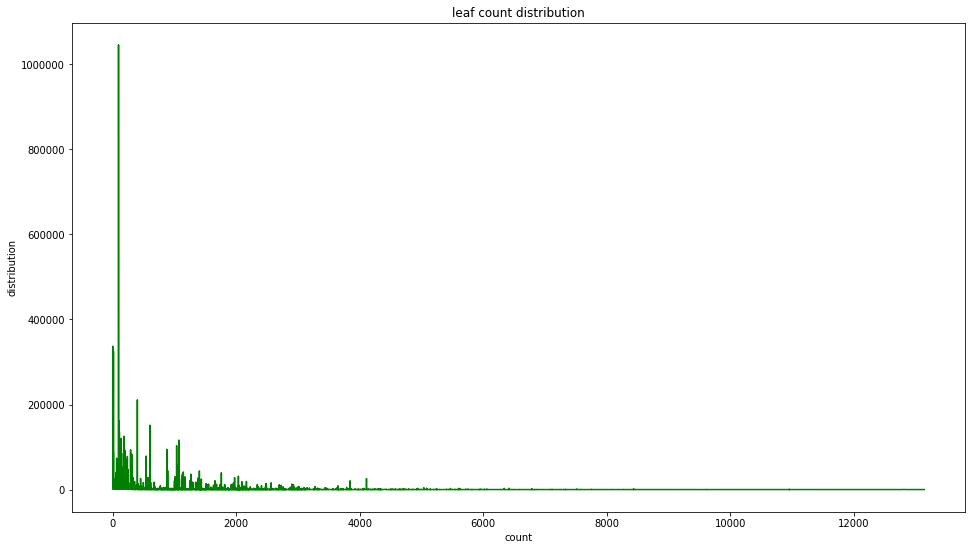

预处理前，非白噪声中最大值大于10的时间序列个数为6132,占比为75.452196%
预处理前，非白噪声中最大值大于20的时间序列个数为4951,占比为60.920389%
预处理前，非白噪声中最大值大于30的时间序列个数为4249,占比为52.282515%
预处理前，非白噪声中最大值大于40的时间序列个数为3797,占比为46.720807%
预处理前，非白噪声中最大值大于50的时间序列个数为3461,占比为42.586440%
预处理前，非白噪声中最大值大于60的时间序列个数为3182,占比为39.153439%
预处理前，非白噪声中最大值大于70的时间序列个数为2934,占比为36.101883%
预处理前，非白噪声中最大值大于80的时间序列个数为2733,占比为33.628645%
预处理前，非白噪声中最大值大于90的时间序列个数为2575,占比为31.684508%
预处理前，非白噪声中最大值大于100的时间序列个数为2452,占比为30.171035%
预处理前，非白噪声中最大值大于110的时间序列个数为2321,占比为28.559124%
预处理前，非白噪声中最大值大于120的时间序列个数为2225,占比为27.377876%
预处理前，非白噪声中最大值大于130的时间序列个数为2132,占比为26.233543%
预处理前，非白噪声中最大值大于140的时间序列个数为2034,占比为25.027685%
预处理前，非白噪声中最大值大于150的时间序列个数为1965,占比为24.178664%
预处理前，非白噪声中最大值大于160的时间序列个数为1888,占比为23.231205%
预处理前，非白噪声中最大值大于170的时间序列个数为1841,占比为22.652885%
预处理前，非白噪声中最大值大于180的时间序列个数为1783,占比为21.939215%
预处理前，非白噪声中最大值大于190的时间序列个数为1732,占比为21.311677%
预处理前，非白噪声中最大值大于200的时间序列个数为1686,占比为20.745663%
预处理前，非白噪声中最大值大于210的时间序列个数为1634,占比为20.105820%
预处理前，非白噪声中最大值大于220的时间序列个数为1593,占比为19.601329%
预处理前，非白噪声中最大值大于230的

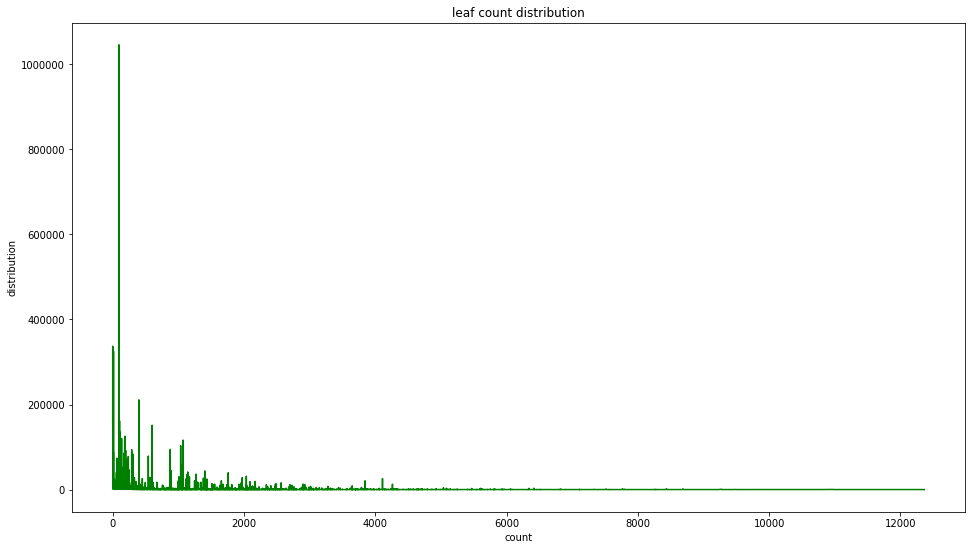

预处理后，非白噪声中最大值大于10的时间序列个数为6166,占比为92.291573%
预处理后，非白噪声中最大值大于20的时间序列个数为5089,占比为76.171232%
预处理后，非白噪声中最大值大于30的时间序列个数为4396,占比为65.798533%
预处理后，非白噪声中最大值大于40的时间序列个数为3929,占比为58.808562%
预处理后，非白噪声中最大值大于50的时间序列个数为3584,占比为53.644664%
预处理后，非白噪声中最大值大于60的时间序列个数为3292,占比为49.274061%
预处理后，非白噪声中最大值大于70的时间序列个数为3033,占比为45.397396%
预处理后，非白噪声中最大值大于80的时间序列个数为2822,占比为42.239186%
预处理后，非白噪声中最大值大于90的时间序列个数为2656,占比为39.754528%
预处理后，非白噪声中最大值大于100的时间序列个数为2526,占比为37.808711%
预处理后，非白噪声中最大值大于110的时间序列个数为2387,占比为35.728184%
预处理后，非白噪声中最大值大于120的时间序列个数为2291,占比为34.291274%
预处理后，非白噪声中最大值大于130的时间序列个数为2196,占比为32.869331%
预处理后，非白噪声中最大值大于140的时间序列个数为2095,占比为31.357581%
预处理后，非白噪声中最大值大于150的时间序列个数为2026,占比为30.324802%
预处理后，非白噪声中最大值大于160的时间序列个数为1946,占比为29.127376%
预处理后，非白噪声中最大值大于170的时间序列个数为1897,占比为28.393953%
预处理后，非白噪声中最大值大于180的时间序列个数为1835,占比为27.465948%
预处理后，非白噪声中最大值大于190的时间序列个数为1783,占比为26.687622%
预处理后，非白噪声中最大值大于200的时间序列个数为1733,占比为25.939231%
预处理后，非白噪声中最大值大于210的时间序列个数为1679,占比为25.130968%
预处理后，非白噪声中最大值大于220的时间序列个数为1635,占比为24.472384%
预处理后，非白噪声中最大值大于230的

In [15]:
maxValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 0)]['max']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(10, 500, 10):
    max1 = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 0) & (leafFirst2Week['max'] > m)]
    print('预处理前，非白噪声中最大值大于%d的时间序列个数为%d,占比为%f%%' % (m, len(max1), len(max1)/len(isNWN)*100))
    
maxValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 0)]['max']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(10, 500, 10):
    max1 = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 0) & (leafFirst2Week['max'] > m)]
    print('预处理后，非白噪声中最大值大于%d的时间序列个数为%d,占比为%f%%' % (m, len(max1), len(max1)/len(isNWNS)*100))

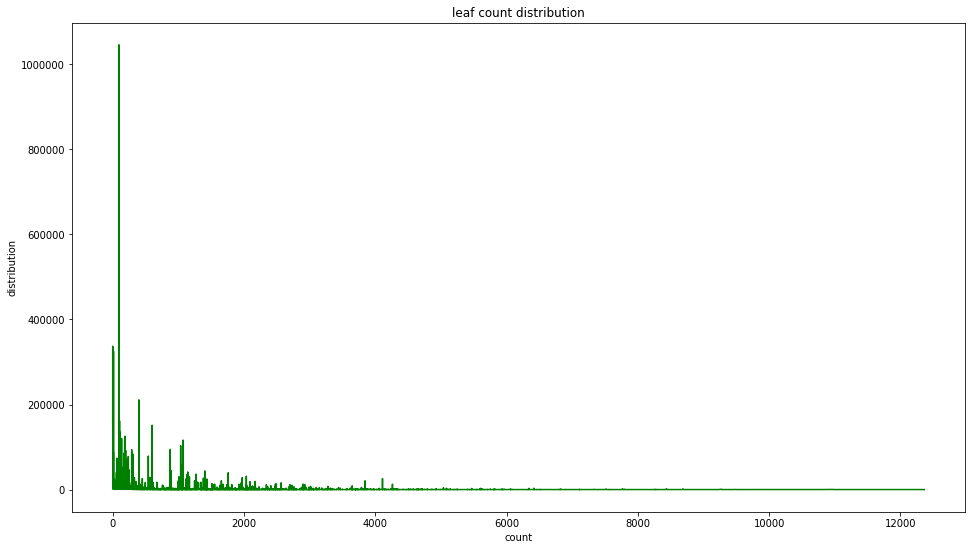

预处理前，白噪声中非零点个数小于500的时间序列个数为6945,占比为98.903446%
预处理前，白噪声中非零点个数小于490的时间序列个数为6942,占比为98.860723%
预处理前，白噪声中非零点个数小于480的时间序列个数为6941,占比为98.846482%
预处理前，白噪声中非零点个数小于470的时间序列个数为6937,占比为98.789519%
预处理前，白噪声中非零点个数小于460的时间序列个数为6932,占比为98.718314%
预处理前，白噪声中非零点个数小于450的时间序列个数为6930,占比为98.689832%
预处理前，白噪声中非零点个数小于440的时间序列个数为6927,占比为98.647109%
预处理前，白噪声中非零点个数小于430的时间序列个数为6924,占比为98.604386%
预处理前，白噪声中非零点个数小于420的时间序列个数为6918,占比为98.518940%
预处理前，白噪声中非零点个数小于410的时间序列个数为6916,占比为98.490459%
预处理前，白噪声中非零点个数小于400的时间序列个数为6911,占比为98.419254%
预处理前，白噪声中非零点个数小于390的时间序列个数为6906,占比为98.348049%
预处理前，白噪声中非零点个数小于380的时间序列个数为6902,占比为98.291085%
预处理前，白噪声中非零点个数小于370的时间序列个数为6894,占比为98.177158%
预处理前，白噪声中非零点个数小于360的时间序列个数为6891,占比为98.134435%
预处理前，白噪声中非零点个数小于350的时间序列个数为6885,占比为98.048989%
预处理前，白噪声中非零点个数小于340的时间序列个数为6882,占比为98.006266%
预处理前，白噪声中非零点个数小于330的时间序列个数为6875,占比为97.906579%
预处理前，白噪声中非零点个数小于320的时间序列个数为6870,占比为97.835375%
预处理前，白噪声中非零点个数小于310的时间序列个数为6862,占比为97.721447%
预处理前，白噪声中非零点个数小于300的时间序列个数为6855,占比为97.621760%
预处理前，白噪声中非零点个数小于290的时间序列个数为6846,占比

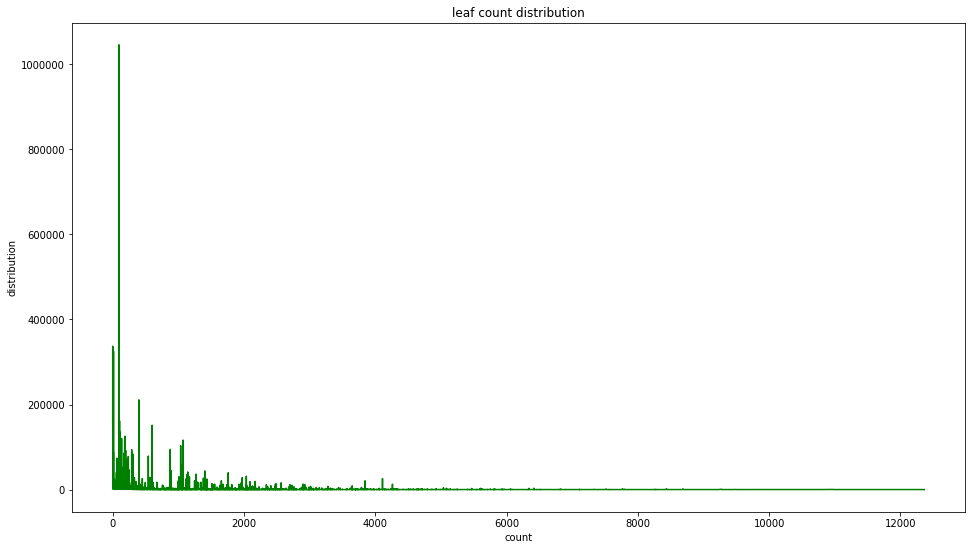

预处理后，白噪声中非零点个数小于500的时间序列个数为8446,占比为99.740198%
预处理后，白噪声中非零点个数小于490的时间序列个数为8443,占比为99.704771%
预处理后，白噪声中非零点个数小于480的时间序列个数为8441,占比为99.681153%
预处理后，白噪声中非零点个数小于470的时间序列个数为8438,占比为99.645725%
预处理后，白噪声中非零点个数小于460的时间序列个数为8435,占比为99.610298%
预处理后，白噪声中非零点个数小于450的时间序列个数为8433,占比为99.586679%
预处理后，白噪声中非零点个数小于440的时间序列个数为8433,占比为99.586679%
预处理后，白噪声中非零点个数小于430的时间序列个数为8431,占比为99.563061%
预处理后，白噪声中非零点个数小于420的时间序列个数为8428,占比为99.527633%
预处理后，白噪声中非零点个数小于410的时间序列个数为8428,占比为99.527633%
预处理后，白噪声中非零点个数小于400的时间序列个数为8425,占比为99.492206%
预处理后，白噪声中非零点个数小于390的时间序列个数为8424,占比为99.480397%
预处理后，白噪声中非零点个数小于380的时间序列个数为8421,占比为99.444969%
预处理后，白噪声中非零点个数小于370的时间序列个数为8418,占比为99.409542%
预处理后，白噪声中非零点个数小于360的时间序列个数为8417,占比为99.397733%
预处理后，白噪声中非零点个数小于350的时间序列个数为8415,占比为99.374114%
预处理后，白噪声中非零点个数小于340的时间序列个数为8412,占比为99.338687%
预处理后，白噪声中非零点个数小于330的时间序列个数为8408,占比为99.291450%
预处理后，白噪声中非零点个数小于320的时间序列个数为8406,占比为99.267832%
预处理后，白噪声中非零点个数小于310的时间序列个数为8402,占比为99.220595%
预处理后，白噪声中非零点个数小于300的时间序列个数为8396,占比为99.149740%
预处理后，白噪声中非零点个数小于290的时间序列个数为8390,占比

In [16]:
countValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 1)]['count']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(500, 0, -10):
    max1 = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 1) & (leafFirst2Week['count'] < m)]
    print('预处理前，白噪声中非零点个数小于%d的时间序列个数为%d,占比为%f%%' % (m, len(max1), len(max1)/len(isWN)*100))
    
countValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 1)]['count']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(500, 0, -10):
    num = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 1) & (leafFirst2Week['count'] < m)]
    print('预处理后，白噪声中非零点个数小于%d的时间序列个数为%d,占比为%f%%' % (m, len(num), len(num)/len(isWNS)*100))

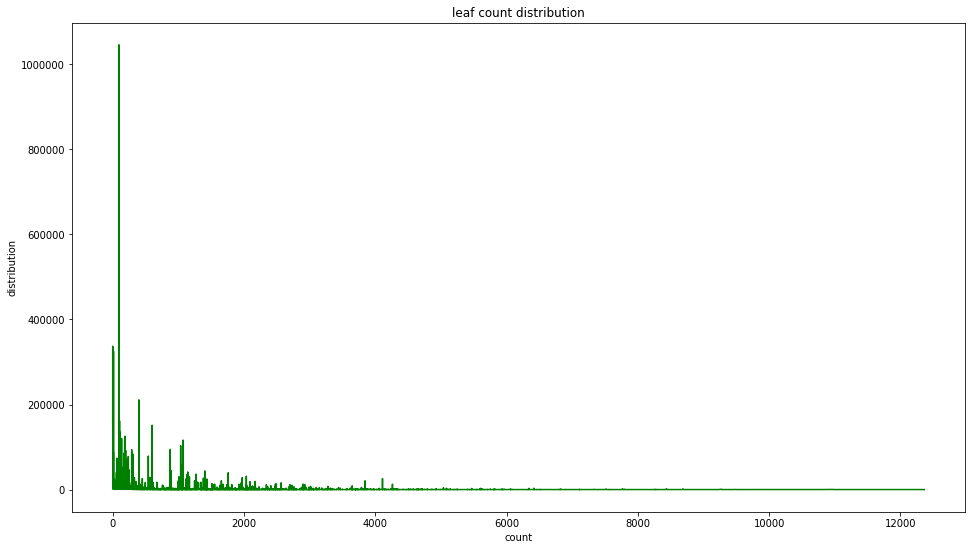

预处理前，非白噪声中非零点个数大于500的时间序列个数为4096,占比为50.399902%
预处理前，非白噪声中非零点个数大于600的时间序列个数为3864,占比为47.545220%
预处理前，非白噪声中非零点个数大于700的时间序列个数为3661,占比为45.047373%
预处理前，非白噪声中非零点个数大于800的时间序列个数为3475,占比为42.758706%
预处理前，非白噪声中非零点个数大于900的时间序列个数为3323,占比为40.888397%
预处理前，非白噪声中非零点个数大于1000的时间序列个数为3176,占比为39.079611%
预处理前，非白噪声中非零点个数大于1100的时间序列个数为3055,占比为37.590747%
预处理前，非白噪声中非零点个数大于1200的时间序列个数为2927,占比为36.015750%
预处理前，非白噪声中非零点个数大于1300的时间序列个数为2793,占比为34.366925%
预处理前，非白噪声中非零点个数大于1400的时间序列个数为2670,占比为32.853451%
预处理前，非白噪声中非零点个数大于1500的时间序列个数为2552,占比为31.401501%
预处理前，非白噪声中非零点个数大于1600的时间序列个数为2439,占比为30.011074%
预处理前，非白噪声中非零点个数大于1700的时间序列个数为2340,占比为28.792913%
预处理前，非白噪声中非零点个数大于1800的时间序列个数为2243,占比为27.599360%
预处理前，非白噪声中非零点个数大于1900的时间序列个数为2145,占比为26.393503%
预处理前，非白噪声中非零点个数大于2000的时间序列个数为2054,占比为25.273779%
预处理前，非白噪声中非零点个数大于2100的时间序列个数为1967,占比为24.203273%
预处理前，非白噪声中非零点个数大于2200的时间序列个数为1872,占比为23.034330%
预处理前，非白噪声中非零点个数大于2300的时间序列个数为1786,占比为21.976129%
预处理前，非白噪声中非零点个数大于2400的时间序列个数为1696,占比为20.868709%
预处理前，非白噪声中非零点个数大于2500的时间序列个数为1614,占比为19.85972

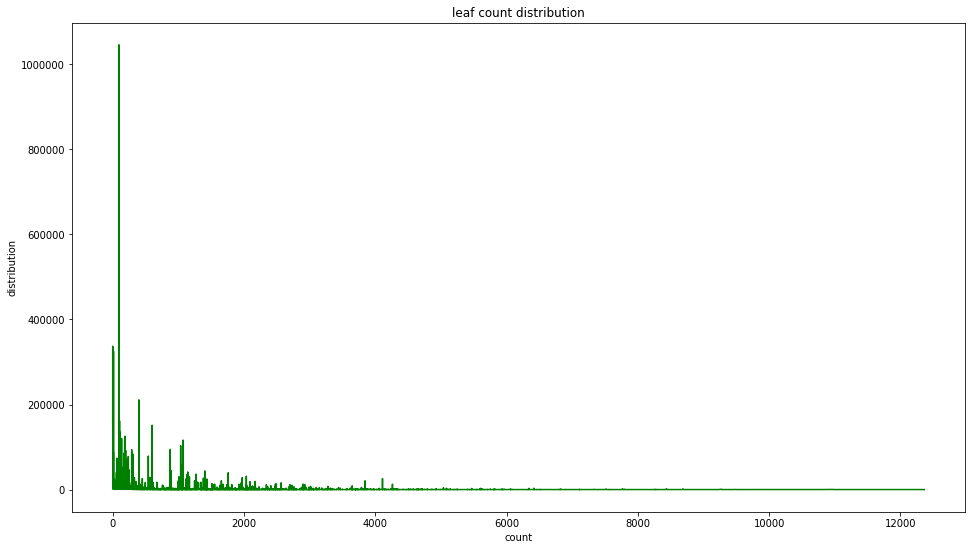

预处理后，非白噪声中非零点个数大于500的时间序列个数为4151,占比为62.131417%
预处理后，非白噪声中非零点个数大于600的时间序列个数为3904,占比为58.434366%
预处理后，非白噪声中非零点个数大于700的时间序列个数为3690,占比为55.231253%
预处理后，非白噪声中非零点个数大于800的时间序列个数为3500,占比为52.387367%
预处理后，非白噪声中非零点个数大于900的时间序列个数为3345,占比为50.067355%
预处理后，非白噪声中非零点个数大于1000的时间序列个数为3195,占比为47.822182%
预处理后，非白噪声中非零点个数大于1100的时间序列个数为3068,占比为45.921269%
预处理后，非白噪声中非零点个数大于1200的时间序列个数为2937,占比为43.960485%
预处理后，非白噪声中非零点个数大于1300的时间序列个数为2803,占比为41.954797%
预处理后，非白噪声中非零点个数大于1400的时间序列个数为2677,占比为40.068852%
预处理后，非白噪声中非零点个数大于1500的时间序列个数为2559,占比为38.302649%
预处理后，非白噪声中非零点个数大于1600的时间序列个数为2444,占比为36.581350%
预处理后，非白噪声中非零点个数大于1700的时间序列个数为2345,占比为35.099536%
预处理后，非白噪声中非零点个数大于1800的时间序列个数为2248,占比为33.647658%
预处理后，非白噪声中非零点个数大于1900的时间序列个数为2149,占比为32.165843%
预处理后，非白噪声中非零点个数大于2000的时间序列个数为2058,占比为30.803772%
预处理后，非白噪声中非零点个数大于2100的时间序列个数为1971,占比为29.501572%
预处理后，非白噪声中非零点个数大于2200的时间序列个数为1875,占比为28.064661%
预处理后，非白噪声中非零点个数大于2300的时间序列个数为1789,占比为26.777429%
预处理后，非白噪声中非零点个数大于2400的时间序列个数为1699,占比为25.430325%
预处理后，非白噪声中非零点个数大于2500的时间序列个数为1617,占比为24.20296

In [17]:
countValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 0)]['count']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(500, 4000, 100):
    num = leafFirst2Week[(leafFirst2Week['isWhiteNoise'] == 0) & (leafFirst2Week['count'] > m)]
    print('预处理前，非白噪声中非零点个数大于%d的时间序列个数为%d,占比为%f%%' % (m, len(num), len(num)/len(isNWN)*100))
    
countValue = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 0)]['count']
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(maxValue, 'g', label='distribution')
plt.show()

for m in range(500, 4000, 100):
    num = leafFirst2Week[(leafFirst2Week['isWhiteNoise_smooth'] == 0) & (leafFirst2Week['count'] > m)]
    print('预处理后，非白噪声中非零点个数大于%d的时间序列个数为%d,占比为%f%%' % (m, len(num), len(num)/len(isNWNS)*100))

#### 根据叶子元素出现频率划分时间序列

In [18]:
c = 400
leafFilterBycount = leafFirst2Week[(leafFirst2Week['count'] > c)]
leafFilterBycountAndWN = leafFilterBycount[leafFilterBycount['isWhiteNoise']==0]
print('非零点个数大于%d的时间序列共%d条，占比%f%%' % (c, len(leafFilterBycount), 100 * len(leafFilterBycount) / len(leafFirst2Week)))
print('其中非高斯白噪声的时间序列占比为%f%%' % (100 * len(leafFilterBycountAndWN) / len(leafFilterBycount)))
leafFilterBycount

非零点个数大于400的时间序列共4478条，占比29.559707%
其中非高斯白噪声的时间序列占比为97.521215%


,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
0,"(i38, e10, c1, p10, l3)",4032,0,0,155294,3548,57780.765625,29841.522919,0,0,145996,3548,57760.683780,29788.155752
1,"(i06, e10, c5, p19, l3)",4032,0,0,337141,4546,78136.378224,37615.773298,0,0,189199,4546,77869.410962,36696.924262
2,"(i38, e10, c1, p13, l3)",4032,0,0,29623,321,9415.018353,4670.152889,0,0,23269,321,9403.066964,4638.199768
3,"(i38, e10, c1, p10, l1)",4032,0,0,4096,1,127.605903,121.192427,0,0,491,1,125.182788,91.135072
4,"(i02, e08, c1, p19, l3)",4032,0,0,5698,63,1405.138393,1077.521768,0,0,4625,63,1403.395337,1072.633302
5,"(i06, e10, c5, p18, l3)",4032,0,0,60682,938,19029.216766,9310.830318,0,0,42582,938,19020.726190,9281.472042
6,"(i06, e10, c5, p14, l4)",4032,0,0,4880,46,1208.133185,634.320192,0,0,3052,46,1206.463542,628.979019
7,"(i38, e11, c1, p07, l2)",4032,0,0,912,7,157.117808,82.324517,0,0,395,7,155.480407,77.053975
8,"(i38, e10, c1, p21, l4)",4032,0,0,6677,61,1643.181052,901.175514,0,0,4332,61,1638.103423,887.068840
9,"(i06, e08, c5, p01, l2)",4032,0,0,10762,162,1883.496280,1072.264618,0,0,5074,162,1868.519097,1017.158666


In [19]:
c = 400
leafFilterBycount = leafFirst2Week[~((leafFirst2Week['count'] > c))]
leafFilterBycountAndWN = leafFilterBycount[leafFilterBycount['isWhiteNoise']==1]
print('非零点个数小于%d的时间序列共%d条，占比%f%%' % (c, len(leafFilterBycount), 100 * len(leafFilterBycount) / len(leafFirst2Week)))
print('其中高斯白噪声的时间序列占比为%f%%' % (100 * len(leafFilterBycountAndWN) / len(leafFilterBycount)))
leafFilterBycount

非零点个数小于400的时间序列共10671条，占比70.440293%
其中高斯白噪声的时间序列占比为64.764314%


,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
4478,"(i43, e03, c1, p12, l3)",400,0,0,12,0,0.181548,0.695990,0,0,2,0,0.127728,0.419993
4479,"(i20, e08, c5, p10, l3)",400,0,0,50,0,0.208333,1.223022,0,0,3,0,0.134425,0.456746
4480,"(i25, e08, c5, p01, l3)",400,0,0,162,0,0.559276,3.933658,0,0,12,0,0.344246,1.388211
4481,"(i02, e09, c4, p28, l3)",400,0,0,5,0,0.143105,0.495623,0,0,1,0,0.089286,0.285156
4482,"(i42, e02, c5, p20, l3)",399,0,0,5,0,0.113839,0.376896,0,0,1,0,0.095238,0.293544
4483,"(i03, e01, c5, p03, l3)",399,0,0,13,0,0.192460,0.815988,0,0,2,0,0.122520,0.407481
4484,"(i09, e09, c5, p15, l3)",399,0,0,9,0,0.124256,0.441169,0,0,1,0,0.094494,0.292515
4485,"(i46, e01, c4, p28, l3)",399,0,0,33,0,0.384673,1.810215,0,0,5,0,0.252480,0.919500
4486,"(i20, e08, c5, p29, l3)",399,0,0,13,0,0.205853,0.857845,0,0,2,0,0.122272,0.407251
4487,"(i38, e09, c4, p23, l2)",399,0,0,24,0,0.283234,1.324800,0,0,4,0,0.168403,0.594839


> 以叶子元素出现频率=400为界限，大于400使用模型预测；小于400使用历史均值。

#### 根据均值划分时间序列

In [20]:
mean = 10
leafFilterByMean = leafFirst2Week[(leafFirst2Week['mean'] > mean)]
leafFilterByMeanAndWN = leafFilterByMean[leafFilterByMean['count']>400]
print('均值大于%f的时间序列共%d条，占比%f%%' % (mean, len(leafFilterByMean), 100 * len(leafFilterByMean) / len(leafFirst2Week)))
print('其中非高斯白噪声的时间序列占比为%f%%' % (100 * len(leafFilterByMeanAndWN) / len(leafFilterByMean)))
leafFilterByMean

均值大于10.000000的时间序列共1409条，占比9.300944%
其中非高斯白噪声的时间序列占比为99.716111%


,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
0,"(i38, e10, c1, p10, l3)",4032,0,0,155294,3548,57780.765625,29841.522919,0,0,145996,3548,57760.683780,29788.155752
1,"(i06, e10, c5, p19, l3)",4032,0,0,337141,4546,78136.378224,37615.773298,0,0,189199,4546,77869.410962,36696.924262
2,"(i38, e10, c1, p13, l3)",4032,0,0,29623,321,9415.018353,4670.152889,0,0,23269,321,9403.066964,4638.199768
3,"(i38, e10, c1, p10, l1)",4032,0,0,4096,1,127.605903,121.192427,0,0,491,1,125.182788,91.135072
4,"(i02, e08, c1, p19, l3)",4032,0,0,5698,63,1405.138393,1077.521768,0,0,4625,63,1403.395337,1072.633302
5,"(i06, e10, c5, p18, l3)",4032,0,0,60682,938,19029.216766,9310.830318,0,0,42582,938,19020.726190,9281.472042
6,"(i06, e10, c5, p14, l4)",4032,0,0,4880,46,1208.133185,634.320192,0,0,3052,46,1206.463542,628.979019
7,"(i38, e11, c1, p07, l2)",4032,0,0,912,7,157.117808,82.324517,0,0,395,7,155.480407,77.053975
8,"(i38, e10, c1, p21, l4)",4032,0,0,6677,61,1643.181052,901.175514,0,0,4332,61,1638.103423,887.068840
9,"(i06, e08, c5, p01, l2)",4032,0,0,10762,162,1883.496280,1072.264618,0,0,5074,162,1868.519097,1017.158666


In [21]:
mean = 10
leafFilterByMean = leafFirst2Week[~(leafFirst2Week['mean'] > mean)]
leafFilterByMeanAndWN = leafFilterByMean[leafFilterByMean['isWhiteNoise']==0]
print('均值大于%f的时间序列共%d条，占比%f%%' % (mean, len(leafFilterByMean), 100 * len(leafFilterByMean) / len(leafFirst2Week)))
print('其中非高斯白噪声的时间序列占比为%f%%' % (100 * len(leafFilterByMeanAndWN) / len(leafFilterByMean)))
leafFilterByMean

均值大于10.000000的时间序列共13740条，占比90.699056%
其中非高斯白噪声的时间序列占比为48.915575%


,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
679,"(i42, e05, c5, p19, l3)",3821,0,0,263,0,8.240079,9.469296,0,0,36,0,7.771081,6.411247
693,"(i38, e11, c4, p03, l2)",3806,0,0,50,0,6.471478,4.481242,0,0,19,0,6.370040,4.108460
702,"(i12, e08, c5, p01, l3)",3790,0,0,97,0,9.206101,7.342252,0,0,31,0,8.973710,6.424956
714,"(i12, e01, c5, p19, l3)",3782,0,0,37,0,7.628720,5.241896,0,0,23,0,7.541915,4.998733
717,"(i38, e11, c4, p01, l2)",3780,0,0,81,0,5.988591,4.562819,0,0,19,0,5.897817,4.060734
719,"(i38, e11, c4, p19, l2)",3778,0,0,79,0,6.900050,5.268220,0,0,22,0,6.767609,4.744495
731,"(i06, e10, c5, p20, l1)",3763,0,0,728,0,9.397569,15.972258,0,0,55,0,9.032490,6.890202
738,"(i38, e11, c1, p31, l2)",3751,0,0,102,0,7.497520,5.215685,0,0,23,0,7.401290,4.728458
745,"(i12, e04, c5, p13, l3)",3741,0,0,68,0,6.823413,6.197643,0,0,25,0,6.622520,5.466562
757,"(i38, e10, c1, p09, l1)",3728,0,0,230,0,9.236111,9.625750,0,0,38,0,8.938244,7.658407


#### 叶子元素出现次数（4032个时间戳中）的分布密度

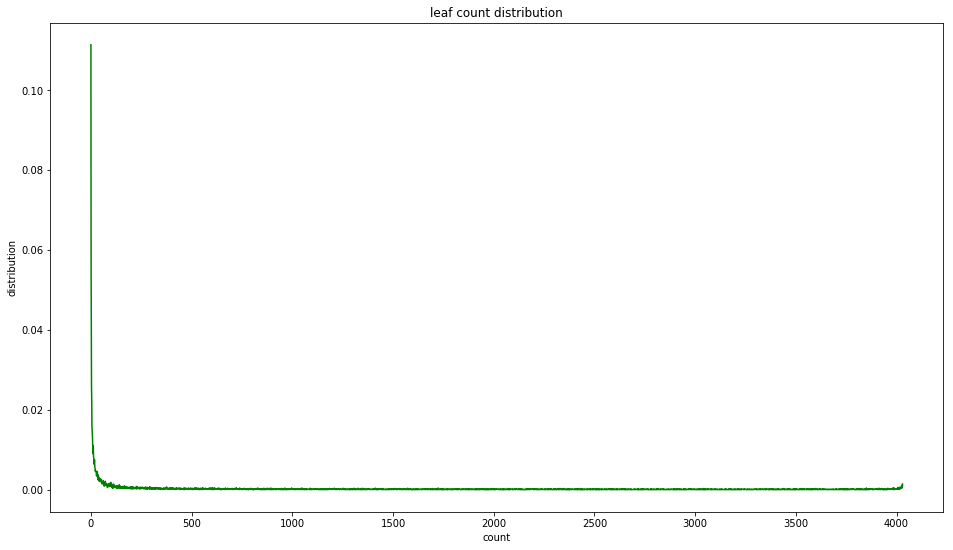

In [22]:
count_distribution = []
for i in range(1, 4032):
    distr = len(leafFirst2Week[leafFirst2Week['count'] == i]) / len(leafFirst2Week)
    count_distribution.append(distr)
plt.figure(figsize=(16, 9))
plt.xlabel('count')
plt.ylabel('distribution')
plt.title('leaf count distribution')
plt.plot(count_distribution, 'g', label='distribution')
plt.show()

In [31]:
leafFirst2Week[leafFirst2Week['diff'] == 0]

,leaf,count,diff,isWhiteNoise,max,min,mean,std,diff_smooth,isWhiteNoise_smooth,max_smooth,min_smooth,mean_smooth,std_smooth
0,"(i38, e10, c1, p10, l3)",4032,0,0,155294,3548,57780.765625,29841.522919,0,0,145996,3548,57760.683780,29788.155752
1,"(i06, e10, c5, p19, l3)",4032,0,0,337141,4546,78136.378224,37615.773298,0,0,189199,4546,77869.410962,36696.924262
2,"(i38, e10, c1, p13, l3)",4032,0,0,29623,321,9415.018353,4670.152889,0,0,23269,321,9403.066964,4638.199768
3,"(i38, e10, c1, p10, l1)",4032,0,0,4096,1,127.605903,121.192427,0,0,491,1,125.182788,91.135072
4,"(i02, e08, c1, p19, l3)",4032,0,0,5698,63,1405.138393,1077.521768,0,0,4625,63,1403.395337,1072.633302
5,"(i06, e10, c5, p18, l3)",4032,0,0,60682,938,19029.216766,9310.830318,0,0,42582,938,19020.726190,9281.472042
6,"(i06, e10, c5, p14, l4)",4032,0,0,4880,46,1208.133185,634.320192,0,0,3052,46,1206.463542,628.979019
7,"(i38, e11, c1, p07, l2)",4032,0,0,912,7,157.117808,82.324517,0,0,395,7,155.480407,77.053975
8,"(i38, e10, c1, p21, l4)",4032,0,0,6677,61,1643.181052,901.175514,0,0,4332,61,1638.103423,887.068840
9,"(i06, e08, c5, p01, l2)",4032,0,0,10762,162,1883.496280,1072.264618,0,0,5074,162,1868.519097,1017.158666


#### 频率小于400的叶子元素预测值使用前一周相同时刻的值

In [24]:
leafFilterCount400 = leafFirst2Week[leafFirst2Week['count']<400]
mae_sum = 0
for leaf in leafFilterCount400['leaf'].tolist():
    ts = pd.read_csv('../result/leaves/leaves_KPISet_smothing/%s.csv' % ('&').join(leaf))
    colName = 'smoothed'
    ts1 = ts[colName][:2016]
    ts2 = ts[colName][2016:]
    eva = Evalutaion()
    mae_sum += eva.evaluate(ts2, ts1, 'MAE', )['MAE']
print('mae: %f' % (mae_sum / len(leafFilterCount400)))

MAE 0.167658730159
MAE 0.213293650794
MAE 0.165178571429
MAE 0.493055555556
MAE 0.226686507937
MAE 0.298115079365
MAE 0.227182539683
MAE 0.968253968254
MAE 0.675099206349
MAE 0.428571428571
MAE 0.244047619048
MAE 0.241567460317
MAE 0.166170634921
MAE 0.25248015873
MAE 0.294146825397
MAE 0.359126984127
MAE 0.330357142857
MAE 0.235615079365
MAE 2.03422619048
MAE 1.16121031746
MAE 0.153273809524
MAE 0.218253968254
MAE 0.287698412698
MAE 0.272321428571
MAE 10.3249007937
MAE 0.346726190476
MAE 0.463293650794
MAE 0.502976190476
MAE 1.68700396825
MAE 0.155257936508
MAE 0.15376984127
MAE 0.262896825397
MAE 0.148313492063
MAE 0.613095238095
MAE 0.16369047619
MAE 0.276785714286
MAE 4.68005952381
MAE 0.498015873016
MAE 0.228174603175
MAE 0.351686507937
MAE 0.345238095238
MAE 0.252976190476
MAE 0.222222222222
MAE 0.204365079365
MAE 1.28224206349
MAE 0.353670634921
MAE 0.157242063492
MAE 0.284226190476
MAE 0.762896825397
MAE 0.206349206349
MAE 0.187996031746
MAE 0.210317460317
MAE 0.228174603175
MA

MAE 0.309523809524
MAE 0.182043650794
MAE 0.113591269841
MAE 0.125
MAE 0.0
MAE 0.46875
MAE 0.121031746032
MAE 0.15128968254
MAE 0.703869047619
MAE 0.938492063492
MAE 0.166666666667
MAE 1.2058531746
MAE 0.116567460317
MAE 0.49255952381
MAE 0.154265873016
MAE 0.159226190476
MAE 0.543154761905
MAE 0.501984126984
MAE 0.179563492063
MAE 0.119543650794
MAE 0.91121031746
MAE 0.145833333333
MAE 0.152777777778
MAE 0.390873015873
MAE 0.126984126984
MAE 1.22420634921
MAE 0.114087301587
MAE 0.345734126984
MAE 0.409226190476
MAE 0.0
MAE 1.22767857143
MAE 0.117063492063
MAE 0.209821428571
MAE 0.183531746032
MAE 0.139880952381
MAE 0.295138888889
MAE 0.186507936508
MAE 0.469742063492
MAE 0.397817460317
MAE 0.220238095238
MAE 0.122023809524
MAE 0.159226190476
MAE 0.111111111111
MAE 0.191468253968
MAE 0.0
MAE 0.135416666667
MAE 0.0
MAE 0.106150793651
MAE 0.47619047619
MAE 2.05853174603
MAE 0.624503968254
MAE 0.146825396825
MAE 0.22619047619
MAE 0.333333333333
MAE 0.154761904762
MAE 0.226686507937
MAE 0.

MAE 0.0922619047619
MAE 0.644345238095
MAE 0.196428571429
MAE 0.0709325396825
MAE 0.0882936507937
MAE 0.0
MAE 0.510416666667
MAE 0.323412698413
MAE 0.28373015873
MAE 0.0848214285714
MAE 0.110615079365
MAE 0.559027777778
MAE 0.0
MAE 0.0704365079365
MAE 0.0634920634921
MAE 0.141865079365
MAE 0.0977182539683
MAE 0.0818452380952
MAE 0.316964285714
MAE 0.0798611111111
MAE 0.0863095238095
MAE 0.171626984127
MAE 0.0
MAE 0.0892857142857
MAE 0.0684523809524
MAE 0.0868055555556
MAE 0.0982142857143
MAE 1.91418650794
MAE 0.170634920635
MAE 0.115575396825
MAE 0.0590277777778
MAE 0.109623015873
MAE 0.102678571429
MAE 0.0798611111111
MAE 0.266865079365
MAE 0.0739087301587
MAE 0.0793650793651
MAE 0.0912698412698
MAE 0.0813492063492
MAE 2.98462301587
MAE 0.209821428571
MAE 0.159722222222
MAE 0.101686507937
MAE 0.161706349206
MAE 0.0813492063492
MAE 0.195932539683
MAE 0.154761904762
MAE 0.0
MAE 0.389880952381
MAE 0.474206349206
MAE 0.0699404761905
MAE 0.485119047619
MAE 0.143849206349
MAE 0.185515873016

MAE 0.0585317460317
MAE 0.0610119047619
MAE 0.0897817460317
MAE 0.0510912698413
MAE 0.046626984127
MAE 0.0
MAE 0.0302579365079
MAE 0.0491071428571
MAE 0.062003968254
MAE 0.0446428571429
MAE 0.101686507937
MAE 0.224702380952
MAE 0.047619047619
MAE 0.128968253968
MAE 0.0
MAE 0.0550595238095
MAE 0.0
MAE 0.0
MAE 0.0486111111111
MAE 0.197916666667
MAE 0.047619047619
MAE 0.0
MAE 0.0843253968254
MAE 0.046626984127
MAE 0.0515873015873
MAE 0.0520833333333
MAE 0.391865079365
MAE 0.0590277777778
MAE 0.0
MAE 0.0
MAE 0.116567460317
MAE 0.0590277777778
MAE 0.0496031746032
MAE 0.121527777778
MAE 0.113591269841
MAE 0.346726190476
MAE 0.107638888889
MAE 0.0406746031746
MAE 0.0
MAE 0.0525793650794
MAE 0.0967261904762
MAE 0.133928571429
MAE 0.126488095238
MAE 0.0500992063492
MAE 0.0
MAE 0.0436507936508
MAE 0.0873015873016
MAE 0.0
MAE 0.0595238095238
MAE 0.0
MAE 0.172123015873
MAE 0.186011904762
MAE 0.0436507936508
MAE 0.0
MAE 0.271329365079
MAE 0.0570436507937
MAE 0.0545634920635
MAE 0.217757936508
MAE 0

MAE 0.0386904761905
MAE 0.0957341269841
MAE 0.0
MAE 0.0342261904762
MAE 0.0
MAE 0.030753968254
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0441468253968
MAE 0.0421626984127
MAE 0.0376984126984
MAE 0.0
MAE 0.0
MAE 0.0496031746032
MAE 0.046130952381
MAE 0.0
MAE 0.0198412698413
MAE 0.0367063492063
MAE 0.0
MAE 0.0456349206349
MAE 0.0
MAE 0.0
MAE 0.0327380952381
MAE 0.0843253968254
MAE 0.0401785714286
MAE 0.0927579365079
MAE 0.133432539683
MAE 0.0
MAE 0.0406746031746
MAE 0.144345238095
MAE 0.167162698413
MAE 0.0
MAE 0.510912698413
MAE 0.0456349206349
MAE 0.0322420634921
MAE 0.0332341269841
MAE 0.0337301587302
MAE 0.0520833333333
MAE 0.0580357142857
MAE 0.0
MAE 0.100198412698
MAE 0.114583333333
MAE 0.0
MAE 0.00843253968254
MAE 0.0391865079365
MAE 0.0
MAE 0.0297619047619
MAE 0.0
MAE 0.030753968254
MAE 0.0372023809524
MAE 0.0381944444444
MAE 0.0709325396825
MAE 0.0877976190476
MAE 0.393353174603
MAE 0.157738095238
MAE 0.062996031746
MAE 0.0749007936508
MAE 0.031746031746
MAE 0.0803571428571


MAE 0.0
MAE 0.0
MAE 0.0168650793651
MAE 0.0337301587302
MAE 0.0337301587302
MAE 0.0277777777778
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0302579365079
MAE 0.0252976190476
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00496031746032
MAE 0.0411706349206
MAE 0.0
MAE 0.0
MAE 0.0282738095238
MAE 0.0188492063492
MAE 0.0
MAE 0.0600198412698
MAE 0.0
MAE 0.0
MAE 0.0183531746032
MAE 0.0
MAE 0.0
MAE 0.031746031746
MAE 0.0386904761905
MAE 0.0545634920635
MAE 0.0411706349206
MAE 0.0233134920635
MAE 0.0
MAE 0.0
MAE 0.0168650793651
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0243055555556
MAE 0.0
MAE 0.0
MAE 0.062003968254
MAE 0.0451388888889
MAE 0.0238095238095
MAE 0.0
MAE 0.0659722222222
MAE 0.0560515873016
MAE 0.0
MAE 0.0997023809524
MAE 0.0203373015873
MAE 0.0
MAE 0.0367063492063
MAE 0.015873015873
MAE 0.0
MAE 0.0188492063492
MAE 0.0
MAE 0.0
MAE 0.0208333333333
MAE 0.0694444444444
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0322420634921
MAE 0.0198412698413
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0500992063492
MAE 0.0287698412698
MAE 0.0
MAE 0.0
MAE 0.

MAE 0.0
MAE 0.00496031746032
MAE 0.00992063492063
MAE 0.102182539683
MAE 0.0
MAE 0.0
MAE 0.0887896825397
MAE 0.0213293650794
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.016369047619
MAE 0.000992063492063
MAE 0.0
MAE 0.0218253968254
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0138888888889
MAE 0.0
MAE 0.0
MAE 0.0213293650794
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0248015873016
MAE 0.015376984127
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0248015873016
MAE 0.0287698412698
MAE 0.0
MAE 0.0
MAE 0.0138888888889
MAE 0.0
MAE 0.0
MAE 0.0550595238095
MAE 0.015376984127
MAE 0.00545634920635
MAE 0.0
MAE 0.0
MAE 0.0138888888889
MAE 0.0
MAE 0.0119047619048
MAE 0.0
MAE 0.0
MAE 0.0128968253968
MAE 0.0277777777778
MAE 0.0
MAE 0.0168650793651
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.015376984127
MAE 0.0168650793651
MAE 0.0
MAE 0.0
MAE 0.0133928571429
MAE 0.0322420634921
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0238095238095
MAE 0.00793650793651
MAE 0.0
MAE 0.0
MAE 0.0520833333333
MAE 0.0
MAE 0.0
MAE 0.00744047619048
MAE 0.0
MAE 0.0248015873016
MAE 0.02380952

MAE 0.0133928571429
MAE 0.00248015873016
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00843253968254
MAE 0.0
MAE 0.0
MAE 0.0094246031746
MAE 0.0178571428571
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0119047619048
MAE 0.0094246031746
MAE 0.0
MAE 0.00644841269841
MAE 0.0183531746032
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0223214285714
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0228174603175
MAE 0.0094246031746
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0094246031746
MAE 0.0
MAE 0.016369047619
MAE 0.0
MAE 0.0
MAE 0.00793650793651
MAE 0.0
MAE 0.0
MAE 0.0367063492063
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0109126984127
MAE 0.0277777777778
MAE 0.0
MAE 0.0
MAE 0.00793650793651
MAE 0.00644841269841
MAE 0.0
MAE 0.00545634920635
MAE 0.00198412698413
MAE 0.0
MAE 0.0
MAE 0.0104166666667
MAE 0.016369047619
MAE 0.0
MAE 0.0109126984127
MAE 0.0
MAE 0.00694444444444
MAE 0.0
MAE 0.0014880952381
MAE 0.0
MAE 0.00843253968254
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00992063492063
MAE 0.0143849206349
MAE 0.0
MAE 0.0
MAE 0.015376984127
MAE 0.0
MAE 0.0
MAE 0.0
MAE 

MAE 0.0
MAE 0.0
MAE 0.0119047619048
MAE 0.00843253968254
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0094246031746
MAE 0.0
MAE 0.00297619047619
MAE 0.0
MAE 0.0
MAE 0.00446428571429
MAE 0.0
MAE 0.00297619047619
MAE 0.000992063492063
MAE 0.00694444444444
MAE 0.0262896825397
MAE 0.00446428571429
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00347222222222
MAE 0.0
MAE 0.00496031746032
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0426587301587
MAE 0.0119047619048
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0014880952381
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00545634920635
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0143849206349
MAE 0.0
MAE 0.00396825396825
MAE 0.0
MAE 0.0014880952381
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0198412698413
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0094246031746
MAE 0.0
MAE 0.00595238095238
MAE 0.0
MAE 0.0
MAE 0.01091

MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00198412698413
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00248015873016
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00297619047619
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00347222222222
MAE 0.0014880952381
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00644841269841
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00595238095238
MAE 0.0
MAE 0.0
MAE 0.00644841269841
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00297619047619
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00347222222222
MAE 0.0
MAE 0.00545634920635
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0138888888889
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00248015873016
MAE 0.0
MAE 0.0
MAE 0.0014880952381
MAE 0.0
MAE 0.000992063492063
MAE 0.0
MAE 0.0
MAE 0.00644841269841
MAE 0.0
MAE 0.0
MAE 0.00992063492063
MAE 0.0
MAE 0.0
MAE 0.00297619047619
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0


MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0133928571429
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00297619047619
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00198412698413
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00248015873016
MAE 0.000496031746032
MAE 0.0
MAE 0.0014880952381
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.000992063492063
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00396825396825
MAE 0.0
MAE 0.0
MAE 0.00248015873016
MAE 0.0
MAE 0.0
MAE 0.0
MAE

MAE 0.0
MAE 0.000496031746032
MAE 0.0
MAE 0.0014880952381
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00198412698413
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.00496031746032
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 

MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0


MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0


MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0
MAE 0.0


In [25]:
0.048978 * len(leafFilterCount400)

522.448326